In [6]:
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 



In [7]:
features_df = pd.read_csv("datasets/featuresdf.csv")

In [8]:
features_df.head()

,id,filepath,duration,class_label
0,1400066,./assets/audio_train/1400066_apples.wav,0.759320,apples
1,1400062,./assets/audio_train/1400062_flowers.wav,0.777324,flowers
2,1400049,./assets/audio_train/1400049_worker.wav,0.571156,worker
3,1400051,./assets/audio_train/1400051_water.wav,0.480091,water
4,1400049,./assets/audio_train/1400049_father.wav,0.448073,father


In [9]:
filepath = f'./assets/audio_train/1400049_father.wav'
audio, sr = librosa.load(filepath)
mfccs = librosa.feature.mfcc(y = audio, sr=sr, n_mfcc=40)

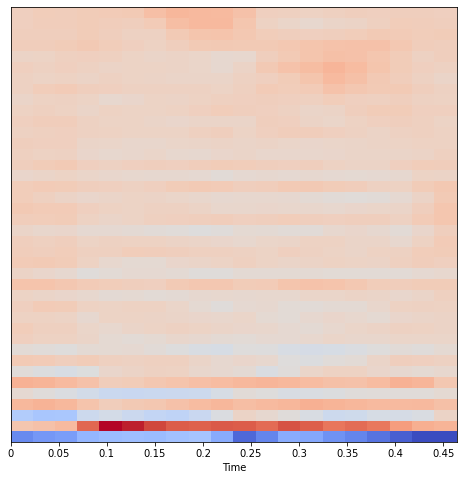

In [10]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=sr, x_axis = 'time')

In [11]:
mfccs.shape

(40, 20)

In [12]:
mfccs

array([[-1.96346878e+02, -1.79968414e+02, -1.73948914e+02,
        -1.40422562e+02, -1.30837280e+02, -1.27352371e+02,
        -1.30908127e+02, -1.21989059e+02, -1.16357872e+02,
        -1.56346008e+02, -2.33684799e+02, -2.01312592e+02,
        -1.54644608e+02, -1.60986404e+02, -1.86442413e+02,
        -2.01413818e+02, -2.20349533e+02, -2.41758011e+02,
        -2.62189514e+02, -2.62184204e+02],
       [ 1.77322083e+01,  2.43227654e+01,  3.50402985e+01,
         1.25764130e+02,  1.88848480e+02,  1.77813965e+02,
         1.53549866e+02,  1.35759369e+02,  1.32387604e+02,
         1.36715790e+02,  1.34408569e+02,  1.23432152e+02,
         1.43213623e+02,  1.33257278e+02,  1.11394722e+02,
         1.21203140e+02,  1.09763245e+02,  7.17845459e+01,
         5.06944618e+01,  4.38083000e+01],
       [-1.01654694e+02, -1.13328751e+02, -1.11931900e+02,
        -6.33613739e+01, -5.28529968e+01, -6.58507996e+01,
        -7.88319702e+01, -8.26968231e+01, -6.97221756e+01,
        -4.02028198e+01, -9.9

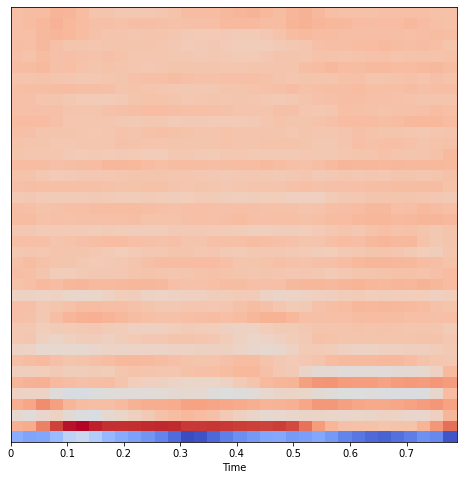

In [13]:
filepath = f'./assets/audio_train/1400062_flowers.wav'
audio, sr = librosa.load(filepath)
mfccs = librosa.feature.mfcc(y = audio, sr=sr, n_mfcc=40)
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=sr, x_axis = 'time')

In [9]:
mfccs.shape

(40, 34)

## 3. Preprocessing

There are many ways of preprocessing audio files and the methods of preprocessing is heavily dependent on the type of classification model which will be used.

The model I will be building is:

1. Feedforward Neural Network
2. Convolutional Neural Network
3. Ensemble Method

#### Preproccessing for FNN

There are a few ways to process the audio for a simple feedforward neural network. The first and most common way is to find the average of each coefficient of the MFCC across time, which will give us a shape of (40,1) dimensions. 


In [14]:
def get_mfccs_features(file_list):
    features = {}
    mean = []
    std = []
    delta_mean = []
    delta_std = []
    for f in file_list:
        audio, sr = librosa.load(f) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs_delta = librosa.feature.delta(mfccs)
        
        mfccs_mean = np.mean(mfccs.T,axis=0)
        mean.append(mfccs_mean)
        
        mfccs_std = np.std(mfccs.T,axis=0)
        std.append(mfccs_std)
        
        mfccs_delta_mean = np.mean(mfccs_delta.T,axis=0)
        delta_mean.append(mfccs_delta_mean)
        
        mfccs_delta_std = np.std(mfccs_delta.T,axis=0)
        delta_std.append(mfccs_delta_std)
    
    features['mfccs_mean'] = mean
    features['mfccs_std'] = std
    features['mfccs_delta_mean'] = delta_mean
    features['mfccs_delta_std'] = delta_std
    
    return features

In [15]:
# get all the features

mfccs_features = get_mfccs_features(features_df['filepath'])

In [16]:
# add them into the dataframe

for k, v in mfccs_features.items():
    features_df[k] = v

In [17]:
combined_features = []
for n in range(0,len(features_df)):
    combined_features.append(np.concatenate((features_df['mfccs_mean'][n],features_df['mfccs_std'][n], features_df['mfccs_delta_mean'][n],features_df['mfccs_delta_std'][n])))
features_df['combined_mfccs'] = combined_features

In [18]:
X_1 = features_df['mfccs_mean']

In [19]:
X_1 = np.array(X_1.tolist())

In [21]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(features_df['class_label'].tolist()))
y = np.array(y)

In [22]:
X_train_1, X_test_1, y_train, y_test = train_test_split(X_1, y, test_size = 0.2, random_state = 42, stratify = y)

**Pre-processing For CNN**

In [23]:
def get_mel(filename):
    audio, sr = librosa.load(filename)
    mel= librosa.feature.melspectrogram(audio, sr=sr)
    mel = librosa.util.fix_length(mel,39)
    return mel.T

In [24]:
features_df['mel'] = features_df['filepath'].map(get_mel)

In [25]:
X_cnn = np.array(features_df['mel'].tolist())

In [26]:
X_cnn.shape

(553, 39, 128)

In [27]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(features_df['class_label'].tolist()))
y = np.array(y)

In [28]:
y.shape

(553, 5)

In [29]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size = 0.2, random_state = 42, stratify = y)

In [30]:
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], 39, 128, 1)
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], 39, 128, 1)


## 4. Modelling

Model 1: Vanilla Base-line model

FNN with MFCCS mean
Dimension = 40
layers = 2

In [33]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(40,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2624      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 7,109
Trainable params: 7,109
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(X_train_1, y_train, validation_data=(X_test_1, y_test), batch_size=32, epochs = 50, verbose=2)

Epoch 1/50
14/14 - 0s - loss: 10.6207 - accuracy: 0.2738 - val_loss: 6.0312 - val_accuracy: 0.3153
Epoch 2/50
14/14 - 0s - loss: 3.7275 - accuracy: 0.3575 - val_loss: 2.8992 - val_accuracy: 0.3964
Epoch 3/50
14/14 - 0s - loss: 2.4552 - accuracy: 0.4570 - val_loss: 2.2794 - val_accuracy: 0.4234
Epoch 4/50
14/14 - 0s - loss: 1.8391 - accuracy: 0.5045 - val_loss: 2.1098 - val_accuracy: 0.4144
Epoch 5/50
14/14 - 0s - loss: 1.6193 - accuracy: 0.5701 - val_loss: 1.7510 - val_accuracy: 0.4595
Epoch 6/50
14/14 - 0s - loss: 1.3186 - accuracy: 0.5792 - val_loss: 1.5622 - val_accuracy: 0.5586
Epoch 7/50
14/14 - 0s - loss: 1.1744 - accuracy: 0.6086 - val_loss: 1.4248 - val_accuracy: 0.6126
Epoch 8/50
14/14 - 0s - loss: 1.1039 - accuracy: 0.6267 - val_loss: 1.5189 - val_accuracy: 0.5766
Epoch 9/50
14/14 - 0s - loss: 1.0365 - accuracy: 0.6380 - val_loss: 1.4239 - val_accuracy: 0.5856
Epoch 10/50
14/14 - 0s - loss: 0.9435 - accuracy: 0.6900 - val_loss: 1.3711 - val_accuracy: 0.6036
Epoch 11/50
14/14 

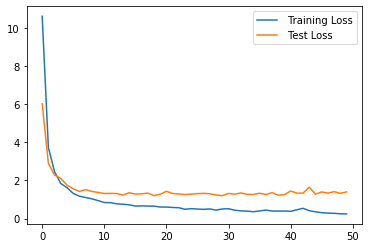

In [37]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

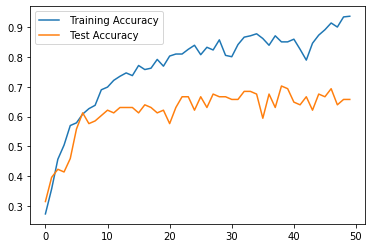

In [38]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

Model 2

Classifier: FNN
Features: 40 coef * 4 indicators (mean and std, delta mean delta std)
dimension 160


In [39]:
X = np.array(features_df['combined_mfccs'].tolist())
le = LabelEncoder()
y = to_categorical(le.fit_transform(features_df['class_label'].tolist()))
y = np.array(y)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [41]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(160,)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(5, activation='softmax'))

In [42]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [43]:
X_train.shape

(442, 160)

In [44]:
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs = 50, verbose=2)

Epoch 1/50
14/14 - 0s - loss: 9.5720 - accuracy: 0.3484 - val_loss: 2.8896 - val_accuracy: 0.3514
Epoch 2/50
14/14 - 0s - loss: 2.2043 - accuracy: 0.4593 - val_loss: 1.3846 - val_accuracy: 0.5676
Epoch 3/50
14/14 - 0s - loss: 1.1435 - accuracy: 0.6629 - val_loss: 0.9538 - val_accuracy: 0.7387
Epoch 4/50
14/14 - 0s - loss: 0.7781 - accuracy: 0.7376 - val_loss: 0.8298 - val_accuracy: 0.7658
Epoch 5/50
14/14 - 0s - loss: 0.5910 - accuracy: 0.7851 - val_loss: 0.7422 - val_accuracy: 0.7387
Epoch 6/50
14/14 - 0s - loss: 0.4846 - accuracy: 0.8167 - val_loss: 0.6939 - val_accuracy: 0.7748
Epoch 7/50
14/14 - 0s - loss: 0.3961 - accuracy: 0.8462 - val_loss: 0.6637 - val_accuracy: 0.7748
Epoch 8/50
14/14 - 0s - loss: 0.3523 - accuracy: 0.8756 - val_loss: 0.6004 - val_accuracy: 0.8018
Epoch 9/50
14/14 - 0s - loss: 0.2892 - accuracy: 0.8891 - val_loss: 0.5923 - val_accuracy: 0.8378
Epoch 10/50
14/14 - 0s - loss: 0.2411 - accuracy: 0.9276 - val_loss: 0.5440 - val_accuracy: 0.8108
Epoch 11/50
14/14 -

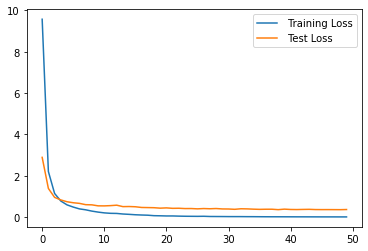

In [45]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

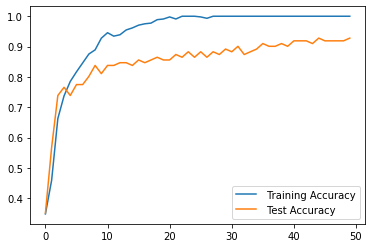

In [46]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

**CNN**

In [47]:
model3 = Sequential()
model3.add(Conv2D(filters = 6, kernel_size=3, activation = 'relu', input_shape = (39,128,1), padding = 'same'))
model3.add(MaxPooling2D(pool_size= (2,2), padding='same'))
model3.add(Conv2D(32, kernel_size=3, activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model3.add(Flatten())
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(5, activation = 'softmax'))

In [48]:
model3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [49]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 128, 6)        60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 64, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 62, 32)        1760      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 31, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8928)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                571456    
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [50]:
history = model3.fit(X_train_cnn,
                        y_train_cnn,
                        batch_size=32,
                        validation_data=(X_test_cnn, y_test_cnn),
                        epochs=100,
                        verbose=2)

Epoch 1/100
14/14 - 1s - loss: 8.4346 - accuracy: 0.3348 - val_loss: 1.8179 - val_accuracy: 0.5405
Epoch 2/100
14/14 - 1s - loss: 1.1835 - accuracy: 0.6787 - val_loss: 1.5925 - val_accuracy: 0.5946
Epoch 3/100
14/14 - 1s - loss: 0.6146 - accuracy: 0.7896 - val_loss: 0.8719 - val_accuracy: 0.7117
Epoch 4/100
14/14 - 1s - loss: 0.3554 - accuracy: 0.8869 - val_loss: 0.8729 - val_accuracy: 0.7027
Epoch 5/100
14/14 - 1s - loss: 0.2259 - accuracy: 0.9208 - val_loss: 0.7629 - val_accuracy: 0.7117
Epoch 6/100
14/14 - 1s - loss: 0.1760 - accuracy: 0.9434 - val_loss: 0.7228 - val_accuracy: 0.7658
Epoch 7/100
14/14 - 1s - loss: 0.1141 - accuracy: 0.9796 - val_loss: 0.7949 - val_accuracy: 0.7928
Epoch 8/100
14/14 - 1s - loss: 0.0822 - accuracy: 0.9864 - val_loss: 0.6874 - val_accuracy: 0.7838
Epoch 9/100
14/14 - 1s - loss: 0.0552 - accuracy: 0.9955 - val_loss: 0.6855 - val_accuracy: 0.7748
Epoch 10/100
14/14 - 1s - loss: 0.0416 - accuracy: 1.0000 - val_loss: 0.7303 - val_accuracy: 0.7658
Epoch 11/

Epoch 82/100
14/14 - 1s - loss: 3.5663e-04 - accuracy: 1.0000 - val_loss: 0.9952 - val_accuracy: 0.8559
Epoch 83/100
14/14 - 1s - loss: 3.4634e-04 - accuracy: 1.0000 - val_loss: 0.9987 - val_accuracy: 0.8559
Epoch 84/100
14/14 - 1s - loss: 3.3524e-04 - accuracy: 1.0000 - val_loss: 1.0061 - val_accuracy: 0.8559
Epoch 85/100
14/14 - 1s - loss: 3.2613e-04 - accuracy: 1.0000 - val_loss: 1.0107 - val_accuracy: 0.8559
Epoch 86/100
14/14 - 1s - loss: 3.1851e-04 - accuracy: 1.0000 - val_loss: 1.0115 - val_accuracy: 0.8649
Epoch 87/100
14/14 - 1s - loss: 3.0785e-04 - accuracy: 1.0000 - val_loss: 1.0163 - val_accuracy: 0.8559
Epoch 88/100
14/14 - 1s - loss: 2.9924e-04 - accuracy: 1.0000 - val_loss: 1.0186 - val_accuracy: 0.8559
Epoch 89/100
14/14 - 1s - loss: 2.9298e-04 - accuracy: 1.0000 - val_loss: 1.0226 - val_accuracy: 0.8649
Epoch 90/100
14/14 - 1s - loss: 2.8460e-04 - accuracy: 1.0000 - val_loss: 1.0238 - val_accuracy: 0.8559
Epoch 91/100
14/14 - 1s - loss: 2.7639e-04 - accuracy: 1.0000 - 

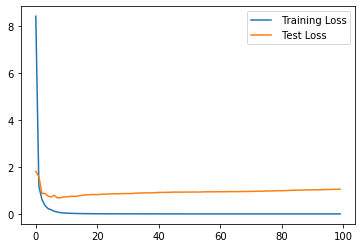

In [51]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

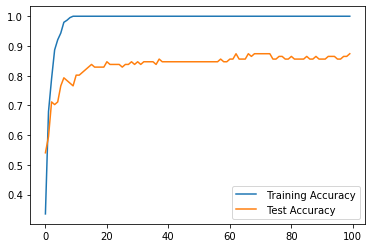

In [52]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()